553467096/553467096 [==============================] - 18s 0us/step
Enter the brand logo name: NIKE-LOGOS
Enter the path to the test image: /content/Nike-SYMOBOL.jpg


Progress: |██████████████████████████████████████████████████| 100.0% Complete

1/1 [==============================] - 0s 18ms/step


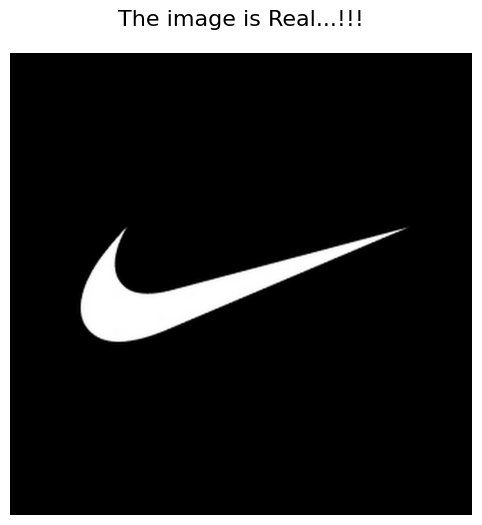

Deleted image: NIKE-LOGOS_1.jpg
Deleted image: NIKE-LOGOS_2.jpg
Deleted image: NIKE-LOGOS_3.jpg
Deleted image: NIKE-LOGOS_4.jpg
Deleted image: NIKE-LOGOS_5.jpg


In [2]:
import requests
from bs4 import BeautifulSoup
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from tensorflow.keras.applications import VGG16
import easyocr

# Function to download an image from a URL
def download_image(url, keyword, index):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for non-200 status codes
        if response.status_code == 200:
            with open(f"{keyword}_{index}.jpg", 'wb') as f:
                f.write(response.content)
            return f"{keyword}_{index}.jpg"
    except requests.exceptions.RequestException as e:
        print(f"Error occurred while downloading image: {str(e)}")
    return None

# Function to search and download images related to a keyword
def search_and_download_images(keyword, max_images=5):
    try:
        search_query = f"https://www.google.com/search?q={keyword}&tbm=isch"
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
        }
        response = requests.get(search_query, headers=headers)
        response.raise_for_status()  # Raise an exception for non-200 status codes

        soup = BeautifulSoup(response.content, 'html.parser')
        img_tags = soup.find_all('img')
        img_urls = [img['src'] for img in img_tags if img.get('src') and img['src'].startswith('http')]

        downloaded_images = []
        for i, img_url in enumerate(img_urls[:max_images]):
            image_path = download_image(img_url, keyword, i + 1)
            if image_path:
                downloaded_images.append(image_path)
        return downloaded_images
    except Exception as e:
        print(f"Error occurred while searching and downloading: {str(e)}")
        return None

# Load and preprocess an image
def load_and_preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    return img_array

# Load VGG16 model
model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# Function to extract features from an image
def extract_features(image_path):
    img = load_and_preprocess_image(image_path)
    features = model.predict(img)
    return features.flatten()

# Function to calculate cosine similarity between two feature vectors
def cosine_similarity(features1, features2):
    dot_product = np.dot(features1, features2)
    norm_features1 = np.linalg.norm(features1)
    norm_features2 = np.linalg.norm(features2)
    similarity = dot_product / (norm_features1 * norm_features2)
    return similarity

# Function to calculate Pearson correlation coefficient between two feature vectors
def pearson_correlation(features1, features2):
    correlation_coefficient, _ = pearsonr(features1, features2)
    return correlation_coefficient

# Function to extract text from an image using EasyOCR
def extract_text(image_path):
    reader = easyocr.Reader(['en'])
    results = reader.readtext(image_path)
    text = ' '.join([result[1] for result in results]) if results else ''
    return text

# Function to calculate image similarity
def calculate_image_similarity(image1_path, image2_path):
    text_similarity = 1 if extract_text(image1_path) == extract_text(image2_path) else -1 if extract_text(
        image1_path) and extract_text(image2_path) else 0
    features1 = extract_features(image1_path)
    features2 = extract_features(image2_path)
    cosine_sim = cosine_similarity(features1, features2)
    pearson_corr = pearson_correlation(features1, features2)
    combined_similarity = (0.4 * cosine_sim) + (0.3 * (pearson_corr + 1) / 2)
    if text_similarity == 1:
        combined_similarity += 1
    elif text_similarity == -1:
        combined_similarity -= 1
    return combined_similarity

if __name__ == "__main__":
    keyword = input("Enter the brand logo name: ")
    test_image_path = input("Enter the path to the test image: ")  # Accept path to test image as input
    test_text = extract_text(test_image_path)

    real_image_paths = search_and_download_images(keyword)
    if real_image_paths:
        similarity_scores = []
        for real_image_path in real_image_paths:
            real_text = extract_text(real_image_path)
            similarity_score = calculate_image_similarity(test_image_path, real_image_path)
            similarity_scores.append((similarity_score, real_image_path))

        similarity_scores.sort(reverse=True)

        if similarity_scores:
            max_similarity_score, _ = similarity_scores[0]
            if max_similarity_score > 0.75:
                prediction = "The image is Real...!!!"
            else:
                prediction = "The image is fake..!!!"
        else:
            prediction = "No similar images found."

        # Displaying the test image with prediction
        plt.figure(figsize=(8, 6))
        plt.imshow(plt.imread(test_image_path))
        plt.title(prediction, fontsize=16, color='Black', loc='center', pad=20)
        plt.axis('off')
        plt.show()
    else:
        print("No images found for the given keyword.")

# Function to delete downloaded images
def delete_downloaded_images(image_paths):
    for image_path in image_paths:
        if os.path.exists(image_path):
            os.remove(image_path)
            print(f"Deleted image: {image_path}")
        else:
            print(f"Image not found: {image_path}")

downloaded_images = search_and_download_images(keyword, max_images=5)

# Delete downloaded images after use
delete_downloaded_images(downloaded_images)